# Assignment 5 - Reinforcement Learning

## *Yiran Chen*
Netid:  *yc390*

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

In [5]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import trange

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [6]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [17]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(20, 8, False)
((27, 8, False), -1, True)


**ANSWER**

In [182]:
## Human reinforcement learning
## play 50 hands of blackjack, and record overall average reward

# initialize 
game = Blackjack()
reward = 0

for i in range(50):
    # for each hand, initialize state0 using deal()
    # initialize step and player sum to be 0
    print(f'\nHand number {i+1}')
    state0 = ((game.deal(), 0, False))
    print(state0)
    
    step = 0
    sumi = 0
    
    while sumi<=21: 
        # make random choice between step 1/2
        step = random.choice([1,2])
        print(f'take step {step}')
        
        # taking step1 hit, keep drawing
        if step==1:
            # update state: 
            # state(player sum, dealer's card, ace), reward, finish
            state = game.step(1)
            sumi = state[0][0]
            reward += state[1]
            print(state)
            #print(game.dealer)
            #print(reward)
        
        # taking step2 stay, play out the dealers hand, and score
        elif step==2:
            # update state: 
            # state(player sum, dealer's card, ace), reward, finish
            state = game.step(2)
            sumi = state[0][0]
            reward += state[1]
            print(state)
            #print(game.dealer)
            #print(reward)
            break
            
print(f'\nThe overall average reward: {reward/50}')            


Hand number 1
((15, 10, False), 0, False)
take step 1
((25, 10, False), -1, True)

Hand number 2
((14, 9, False), 0, False)
take step 1
((20, 9, False), 0, False)
take step 1
((30, 9, False), -1, True)

Hand number 3
((20, 8, False), 0, False)
take step 1
((23, 8, False), -1, True)

Hand number 4
((14, 10, False), 0, False)
take step 1
((24, 10, False), -1, True)

Hand number 5
((19, 7, False), 0, False)
take step 2
((19, 7, False), 1.0, True)

Hand number 6
((18, 4, True), 0, False)
take step 1
((18, 4, False), 0, False)
take step 2
((18, 4, False), -1.0, True)

Hand number 7
((9, 10, False), 0, False)
take step 2
((9, 10, False), -1.0, True)

Hand number 8
((6, 6, False), 0, False)
take step 2
((6, 6, False), 1.0, True)

Hand number 9
((12, 6, False), 0, False)
take step 2
((12, 6, False), 1.0, True)

Hand number 10
((16, 10, False), 0, False)
take step 2
((16, 10, False), -1.0, True)

Hand number 11
((11, 10, False), 0, False)
take step 2
((11, 10, False), 1.0, True)

Hand number 1

## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Relwat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

In [323]:
# (a) Use Monte Carlo policy evaluation to evaluate the expected returns from each state

# final reward for each state
def mcpe(iter_num):
    
    # initialize value-state matrix 
    # (player sum, dealer's card, count)
    val_mat_ace = np.zeros((20,10,2))
    val_mat_no = np.zeros((20,10,2))
    
    # initialize reward list
    reward_list = []
    
    for i in range(iter_num):
        # initialize state list
        states = []
        
        # initialize finish boolean
        finish = False
        
        # initialize game
        game = Blackjack()
        hand0 = game.deal()
        
        # initialize player, dealer index of mat
        sumi = hand0[0]
        player_idx, dealer_idx = sumi-2, hand0[1]-1
        ace = hand0[2]
        step = 0
        
        while (not finish) and (step!=2) and (sumi <= 21):
            # record each intermediate states
            states.append((player_idx, dealer_idx))
            
            # always hit before sum to 20/21
            if sumi < 20:
                step = 1
            # otherwise stay
            else:
                step = 2
            
            # take step
            state = game.step(step)
            hand, reward, finish = state

            # update player sum
            sumi = hand[0]
            
            # update player/dealer idx
            player_idx, dealer_idx = sumi-2, hand[1]-1
        pass
        
        # record reward after each game
        reward_list.append(reward)

        
        # assign end reward to each intermediate states
        for (player_idx, dealer_idx) in states:
            
            # when usable ace
            if ace:
                val_mat_ace[player_idx, dealer_idx][0] += reward
                val_mat_ace[player_idx, dealer_idx][1] += 1

            # when no usable ace
            else:
                val_mat_no[player_idx, dealer_idx][0] += reward
                val_mat_no[player_idx, dealer_idx][1] += 1 
        pass
    
    pass

    # returns nan for 0 count
    val_mat_ace = np.divide(val_mat_ace[:,:,0], val_mat_ace[:,:,1])
    val_mat_no = np.divide(val_mat_no[:,:,0], val_mat_no[:,:,1])
    
    # average reward per episode
    avg_reward = np.cumsum(reward_list)/np.arange(1,iter_num+1)
    
    return val_mat_ace, val_mat_no, avg_reward

In [324]:
# 10,000 episodes
val_mat_ace1, val_mat_no1, avg_reward1 = mcpe(iter_num=10000)

In [416]:
# plot the value of each state under the aggressive policy described
def plot(val_mat_ace, val_mat_no):
    plt.figure(figsize=(12,8))
    plt.suptitle('Value of each state under naive policy (10,000 episodes)')

    plt.subplot(1,2,1)
    plt.title('With usable ace')
    plt.imshow(val_mat_ace, vmin=-1, vmax=1, cmap="RdBu")
    plt.xlabel("Dealer's card")
    plt.ylabel("Player's sum")
    plt.xticks(np.arange(10), list(map(int, np.arange(1,11))))
    plt.yticks(np.arange(20), list(map(int, np.arange(2,22))))
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.title('No usable ace')
    plt.imshow(val_mat_no, vmin=-1, vmax=1, cmap="RdBu")
    plt.xlabel("Dealer's card")
    plt.ylabel("Player's sum")
    plt.xticks(np.arange(10), list(map(int, np.arange(1,11))))
    plt.yticks(np.arange(20), list(map(int, np.arange(2,22))))
    plt.colorbar()
    plt.show()

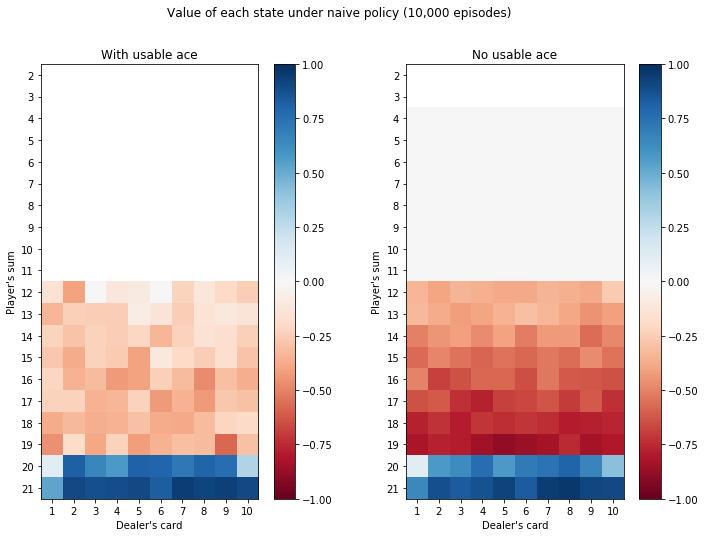

In [417]:
plot(val_mat_ace1, val_mat_no1)

In [325]:
# 500,000 episodes
val_mat_ace2, val_mat_no2, avg_reward2 = mcpe(iter_num=500000)

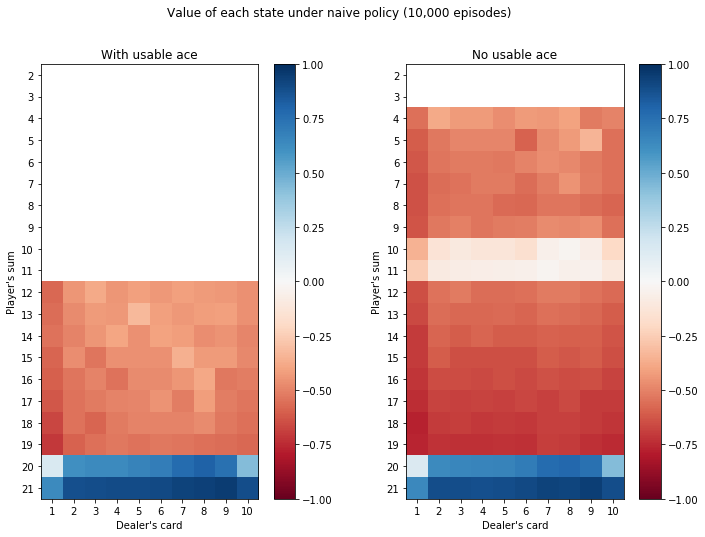

In [328]:
plot(val_mat_ace2, val_mat_no2)

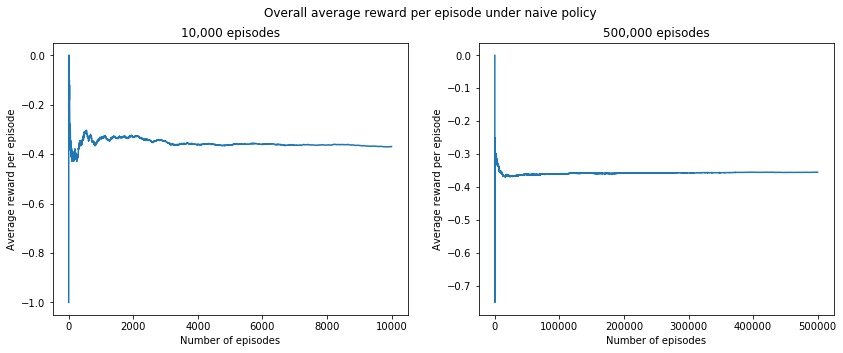

In [329]:
# plot overall average reward per episode vs the number of episodes
plt.figure(figsize=(14,5))
plt.suptitle('Overall average reward per episode under naive policy')

plt.subplot(1,2,1)
plt.title('10,000 episodes')
plt.plot(avg_reward1)
plt.xlabel('Number of episodes')
plt.ylabel('Average reward per episode')
#plt.ylim(-1,1)

plt.subplot(1,2,2)
plt.title('500,000 episodes')
plt.plot(avg_reward2)
plt.xlabel('Number of episodes')
plt.ylabel('Average reward per episode')
#plt.ylim(-1,1)
plt.show()

In [331]:
print(f'With 10,000 episodes, the overall average reward for this policy is {avg_reward1[-1]:.4f}.')
print(f'With 500,000 episode, the overall average reward for this policy is {avg_reward2[-1]:.4f}.')

With 10,000 episodes, the overall average reward for this policy is -0.3688.
With 500,000 episode, the overall average reward for this policy is -0.3546.


## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

**ANSWER**

In [14]:
class MCMC():
    def __init__(self, iter_num=10000, N0=100):
        self.iter_num = iter_num
        self.N0 = N0

        # initialize action_value = (player sum, dealer card, ace, action)
        self.action_value = np.zeros((20,10,2,2))
        self.action_value_counter = np.zeros((20,10,2,2))
        
        # initialize returns list to record reward for each round
        self.returns = []
    
    
    def policy(self, state):

        # epsilon-greedy
        epsilon = self.N0/(self.N0 + np.sum(self.action_value_counter[state]))

        # exploit: pick current best option (step with greatest value)
        if np.random.random() > epsilon:
            step = np.argmax(self.action_value[state])
        # explore: take random option epsilon of the times
        else:
            step = random.choice([0,1])

        return step
        
    
    def policy_eval(self):
        
        # obtain state_action pairs and reward for each game
        for i in trange(self.iter_num):
            state_action, reward = self.one_game()
            
            # for all state_action pairs within each game
            for state_act in state_action:
                # obtain initial count for each state_act pair
                N = self.action_value_counter[state_act]
                
                # update action_value using online average
                self.action_value[state_act] = (reward + N*self.action_value[state_act])/(N+1)
                # update action_value_count
                self.action_value_counter[state_act] += 1
            pass
            # record reward for each round
            self.returns.append(reward)
        pass
             
        
    def one_game(self):
        # initialize one game
        game = Blackjack()
        hand = game.deal()
        state_action = []
        finish = False
        
        while (not finish):
            player_idx, dealer_idx, ace = hand[0]-2, hand[1]-1, int(hand[2])

            # decide which step to take
            step = self.policy((player_idx, dealer_idx, ace))

            # record state_action
            state_action.append((player_idx, dealer_idx, ace)+(step,))

            # take step according to policy
            hand, reward, finish = game.step(step)
        
        return state_action, reward
                
              

In [15]:
mcmc = MCMC(iter_num=8000000, N0=100)

In [16]:
mcmc.policy_eval()

100%|██████████| 8000000/8000000 [12:25<00:00, 10734.99it/s]


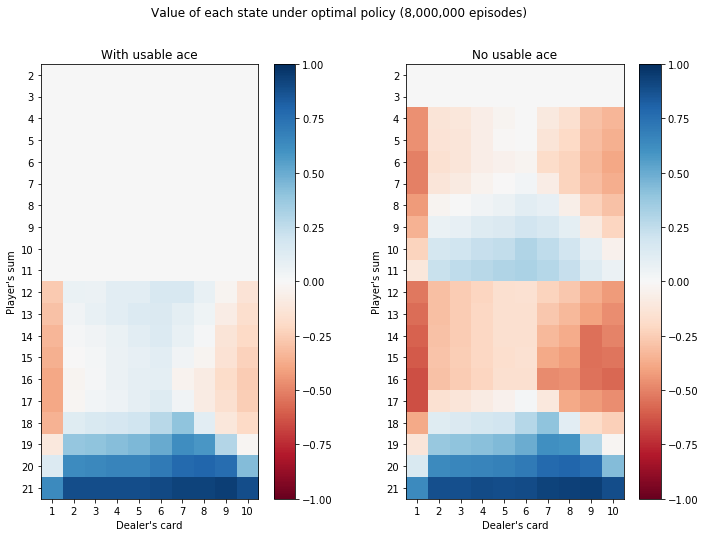

In [17]:
# plotting
state_value = np.max(mcmc.action_value, axis=-1)
policy = np.argmax(mcmc.action_value, axis=-1)

# plot state-value
plt.figure(figsize=(12,8))
plt.suptitle('Value of each state under optimal policy (8,000,000 episodes)')

plt.subplot(1,2,1)
plt.title('With usable ace')
plt.imshow(state_value[:,:,1], vmin=-1, vmax=1, cmap="RdBu")
plt.xlabel("Dealer's card")
plt.ylabel("Player's sum")
plt.xticks(np.arange(10), list(map(int, np.arange(1,11))))
plt.yticks(np.arange(20), list(map(int, np.arange(2,22))))
plt.colorbar()

plt.subplot(1,2,2)
plt.title('No usable ace')
plt.imshow(state_value[:,:,0], vmin=-1, vmax=1, cmap="RdBu")
plt.xlabel("Dealer's card")
plt.ylabel("Player's sum")
plt.xticks(np.arange(10), list(map(int, np.arange(1,11))))
plt.yticks(np.arange(20), list(map(int, np.arange(2,22))))
plt.colorbar()
plt.show()

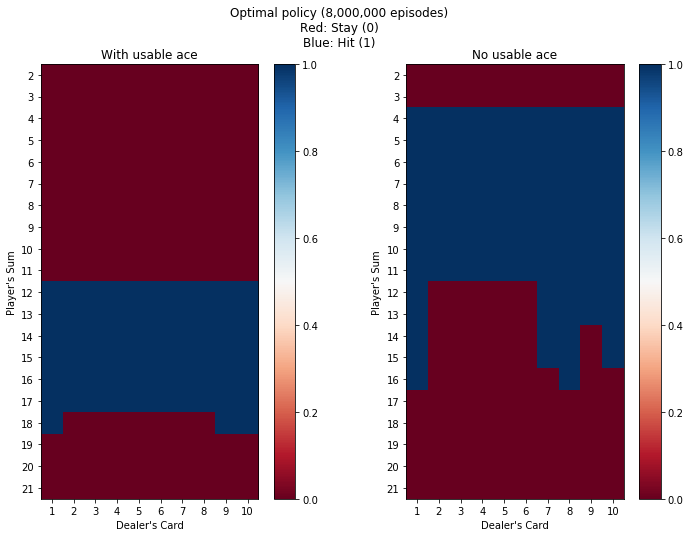

In [18]:
# plot optimal policy-value
plt.figure(figsize=(12,8))
plt.suptitle('Optimal policy (8,000,000 episodes)\nRed: Stay (0)\nBlue: Hit (1)')

plt.subplot(1,2,1)
plt.imshow(policy[:,:,1], cmap='RdBu')
plt.title('With usable ace')
plt.xlabel("Dealer's Card")
plt.ylabel("Player's Sum")
plt.xticks(np.arange(10), list(map(str, np.arange(1,11))))
plt.yticks(np.arange(20), list(map(str, np.arange(2,22))))
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(policy[:,:,0], cmap='RdBu')
plt.title('No usable ace')
plt.xlabel("Dealer's Card")
plt.ylabel("Player's Sum")
plt.xticks(np.arange(10), list(map(str, np.arange(1,11))))
plt.yticks(np.arange(20), list(map(str, np.arange(2,22))))
plt.colorbar()
plt.show()

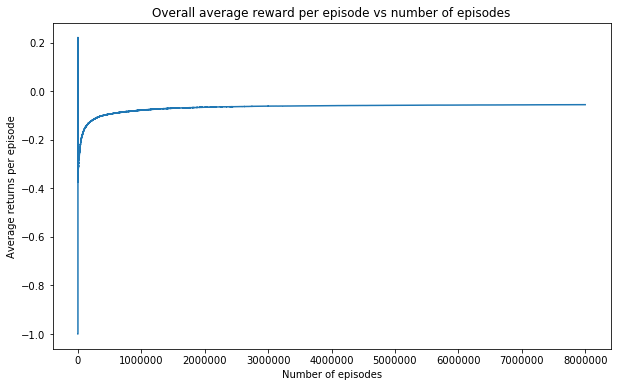

In [19]:
# plot overall average reward per episode vs the number of episodes
avg_returns = np.cumsum(mcmc.returns)/np.arange(1, mcmc.iter_num+1)
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, mcmc.iter_num+1), avg_returns)
plt.title('Overall average reward per episode vs number of episodes')
plt.xlabel('Number of episodes')
plt.ylabel('Average returns per episode')
plt.show()

In [20]:
print(f'The average reward the control strategy was able to achieve is {avg_returns[-1]:.4f}')

The average reward the control strategy was able to achieve is -0.0548


## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

**(a)**

The optimal control policy performs the best. This is because we are able to estimate the value for each state-action pair by playing many iterations of games and recording their respective average returns. This approach takes all possible states into consideration using exploration and exploitation from the epsilon-greedy method. By choosing the action with a higher estimated value, the oplicy is optimal to achieve overal higher average return.


**(b)**

I could not have created a better policy if knowing the full Markov Decision Process for this environment. This is because all possible state-action pairs have been recorded. The policy chooses action with higher estimated value, and guarantees a maximum average return, given a large number of games played.

